# Convolutional Neural Networks
---
In this notebook, I am training a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

In [1]:
import torch
import numpy as np

In [2]:
train_on_gpu=torch.cuda.is_available()
if(train_on_gpu):
    print('CUDA AVAILABLE')
else:
    print('CUDA NOT AVALAIBLE')


CUDA AVAILABLE


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
#no. of subprocesses used for data loding
num_workers=0
#no. of samples per batch loaded
batch_size=20
# % of training data as validation batch size
valid_size=0.2
#converting data into tensor
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
root='data'

train_data=datasets.CIFAR10(root, train=True, transform=transform, download=True)
test_data=datasets.CIFAR10(root,train=False,transform=transform,download=True)

length_train=len(train_data)
indices_train=list(range(length_train))
np.random.shuffle(indices_train)
split=int(np.floor(valid_size*length_train))
train_index,valid_index=indices_train[split:],indices_train[:split]
train_sampler=SubsetRandomSampler(train_index)
valid_sampler=SubsetRandomSampler(valid_index)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def image_show(img):
    img=img/2+0.5 #unnormalize
    plt.imshow(np.transpose(img,(1,2,0)))# converting from tensor

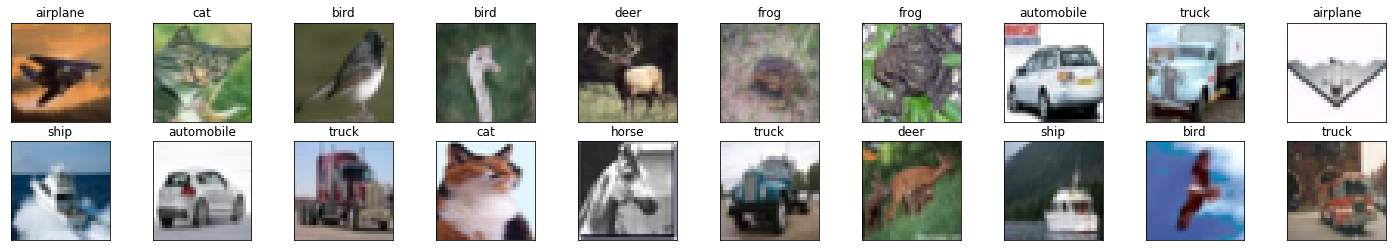

In [6]:
dataiter=iter(train_loader)
images, labels=dataiter.next()
images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    image_show(images[idx])
    ax.set_title(classes[labels[idx]])

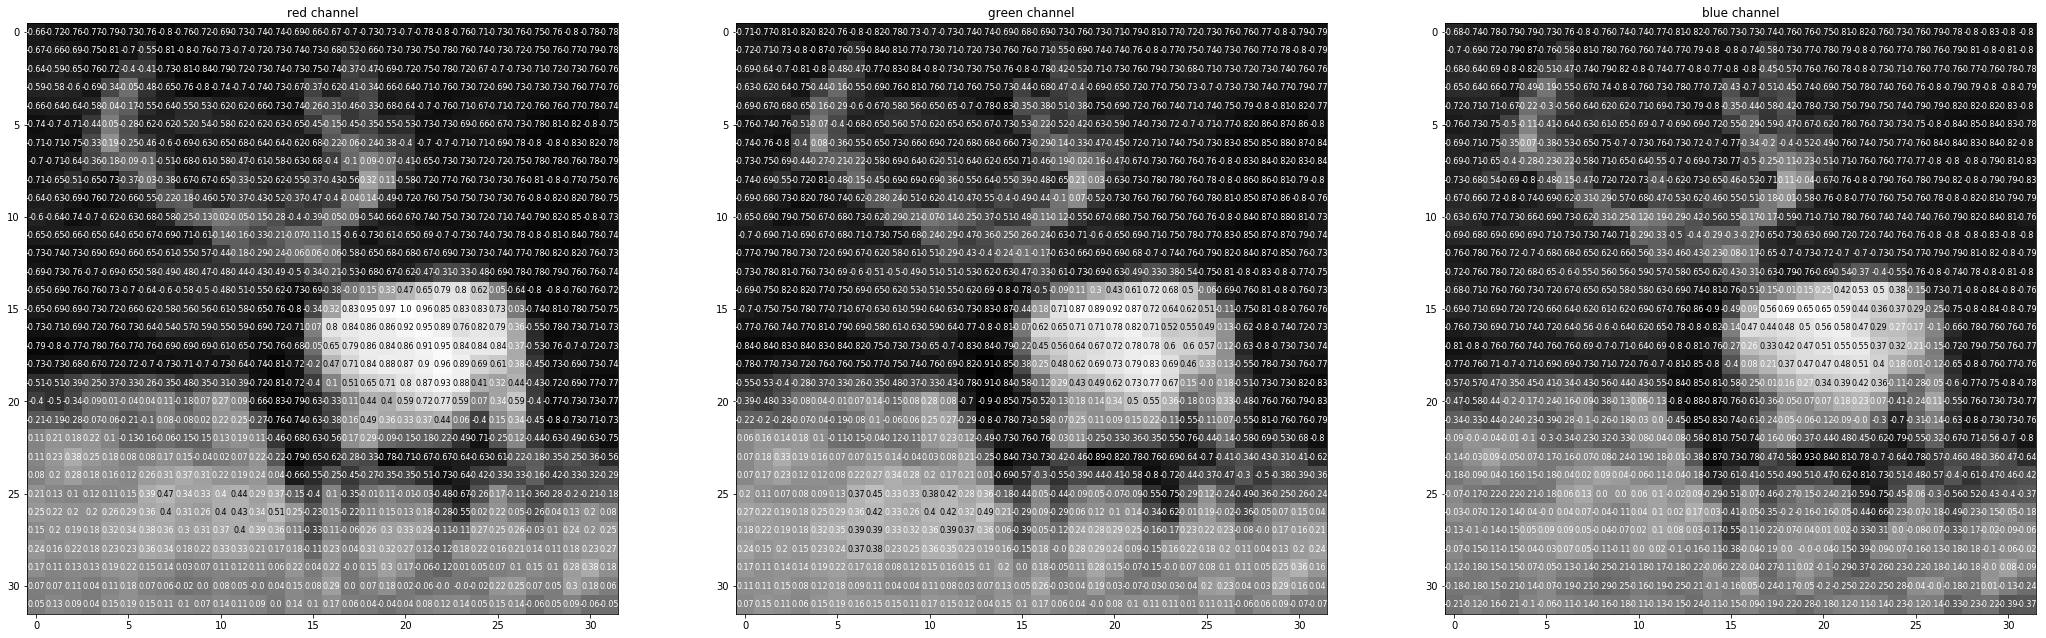

In [7]:
rgb_img=np.squeeze(images[4])
channels=['red channel','green channel','blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,16,3,padding=1)
        self.conv2=nn.Conv2d(16,32,3,padding=1)
        self.conv3=nn.Conv2d(32,64,3,padding=1)
        #final layer with tensor 64*4*4
        #max pooling layer
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(64*4*4,500)
        self.fc2=nn.Linear(500,10)
        self.dropout=nn.Dropout(0.25)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        #conv layer-->activation func -->max pooling layer
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        
        x=x.view(-1,64*4*4)
        x=self.dropout(x)
        x=F.relu(self.fc1(x))
        
        x=self.dropout(x)
        x=self.fc2(x)
        return x

model=Net()
print(model)

if(train_on_gpu):
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [12]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01)

In [17]:
epochs=30

min_vald_loss=np.Inf

for epoch in range(1,epochs+1):
    train_loss=0
    valid_loss=0
    
    model.train()
    for data,targets in train_loader:
        if train_on_gpu:
            data,targets=data.cuda(),targets.cuda()
        optimizer.zero_grad()
        output=model(data)
        loss=criterion(output,targets)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
    #validation loop
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= min_vald_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        min_vald_loss,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar10.pt')
        min_vald_loss = valid_loss

Epoch: 1 	Training Loss: 1.165606 	Validation Loss: 0.271432
Validation loss decreased (inf --> 0.271432).  Saving model ...
Epoch: 2 	Training Loss: 1.074599 	Validation Loss: 0.244908
Validation loss decreased (0.271432 --> 0.244908).  Saving model ...
Epoch: 3 	Training Loss: 1.001693 	Validation Loss: 0.226510
Validation loss decreased (0.244908 --> 0.226510).  Saving model ...
Epoch: 4 	Training Loss: 0.938321 	Validation Loss: 0.213615
Validation loss decreased (0.226510 --> 0.213615).  Saving model ...
Epoch: 5 	Training Loss: 0.884818 	Validation Loss: 0.204654
Validation loss decreased (0.213615 --> 0.204654).  Saving model ...
Epoch: 6 	Training Loss: 0.837715 	Validation Loss: 0.196144
Validation loss decreased (0.204654 --> 0.196144).  Saving model ...
Epoch: 7 	Training Loss: 0.791789 	Validation Loss: 0.186376
Validation loss decreased (0.196144 --> 0.186376).  Saving model ...
Epoch: 8 	Training Loss: 0.755497 	Validation Loss: 0.176888
Validation loss decreased (0.18637

In [18]:
#loading optimal model
model.load_state_dict(torch.load('model_cifar10.pt'))
#testing model
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.725835

Test Accuracy of airplane: 83% (833/1000)
Test Accuracy of automobile: 86% (863/1000)
Test Accuracy of  bird: 61% (613/1000)
Test Accuracy of   cat: 49% (497/1000)
Test Accuracy of  deer: 75% (755/1000)
Test Accuracy of   dog: 63% (634/1000)
Test Accuracy of  frog: 83% (835/1000)
Test Accuracy of horse: 84% (843/1000)
Test Accuracy of  ship: 82% (821/1000)
Test Accuracy of truck: 80% (808/1000)

Test Accuracy (Overall): 75% (7502/10000)
